<a href="https://colab.research.google.com/github/Badabagni1993/636/blob/main/Video_Preprocessing_Project_2_CSC636.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import zipfile


os.mkdir('/content/data')
os.mkdir('/content/data/sequences')

local_zip = '/content/drive/MyDrive/UCF_101_mixing_cuting.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/data')
zip_ref.close()



local_zip = '/content/drive/MyDrive/UCF101TrainTestSplits-RecognitionTask.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()



In [ ]:
"""
After extracting the RAR, run this to move all the files into
the appropriate train/test folders.
"""



import os
import os.path



def get_train_test_lists(version='01'):
    """
    Using one of the train/test files (01, 02, or 03), get the filename
    breakdowns we'll later use to move everything.
    """
    # Get our files based on version.
    test_file = os.path.join('ucfTrainTestlist', 'testlist' + version + '.txt')
    train_file = os.path.join('ucfTrainTestlist', 'trainlist' + version + '.txt')

    # Build the test list.
    with open(test_file) as fin:
        test_list = [row.strip() for row in list(fin)]

    # Build the train list. Extra step to remove the class index.
    with open(train_file) as fin:
        train_list = [row.strip() for row in list(fin)]
        train_list = [row.split(' ')[0] for row in train_list]

    # Set the groups in a dictionary.
    file_groups = {
        'train': train_list,
        'test': test_list
    }

    return file_groups

def move_files(file_groups):
    """This assumes all of our files are currently in _this_ directory.
    So move them to the appropriate spot. Only needs to happen once.
    """
    # Do each of our groups.
    for group, videos in file_groups.items():

        # Do each of our videos.
        for video in videos:

            # Get the parts.
            parts = video.split(os.path.sep)
            classname = parts[0]
            filename = parts[1]

            # Check if this class exists.
            if not os.path.exists(os.path.join(group, classname)):
                print("Creating folder for %s/%s" % (group, classname))
                os.makedirs(os.path.join(group, classname))

            # Check if we have already moved this file, or at least that it
            # exists to move.
            if not os.path.exists(filename):
                print("Can't find %s to move. Skipping." % (filename))
                continue

            # Move it.
            dest = os.path.join(group, classname, filename)
            print("Moving %s to %s" % (filename, dest))
            os.rename(filename, dest)

    print("Done.")

def main():
    """
    Go through each of our train/test text files and move the videos
    to the right place.
    """
    # Get the videos in groups so we can move them.
    group_lists = get_train_test_lists()

    # Move the files.
    move_files(group_lists)

if __name__ == '__main__':
    main()


Streaming output truncated to the last 5000 lines.
Can't find v_Surfing_g19_c04.avi to move. Skipping.
Can't find v_Surfing_g20_c01.avi to move. Skipping.
Can't find v_Surfing_g20_c02.avi to move. Skipping.
Can't find v_Surfing_g20_c03.avi to move. Skipping.
Can't find v_Surfing_g20_c04.avi to move. Skipping.
Can't find v_Surfing_g20_c05.avi to move. Skipping.
Can't find v_Surfing_g20_c06.avi to move. Skipping.
Can't find v_Surfing_g21_c01.avi to move. Skipping.
Can't find v_Surfing_g21_c02.avi to move. Skipping.
Can't find v_Surfing_g21_c03.avi to move. Skipping.
Can't find v_Surfing_g21_c04.avi to move. Skipping.
Can't find v_Surfing_g22_c01.avi to move. Skipping.
Can't find v_Surfing_g22_c02.avi to move. Skipping.
Can't find v_Surfing_g22_c03.avi to move. Skipping.
Can't find v_Surfing_g22_c04.avi to move. Skipping.
Can't find v_Surfing_g23_c01.avi to move. Skipping.
Can't find v_Surfing_g23_c02.avi to move. Skipping.
Can't find v_Surfing_g23_c03.avi to move. Skipping.
Can't find v_

In [ ]:

import csv
import glob
import os.path
from subprocess import call
import os

def extract_files():
    data_file = []
    folders = ['train','test']
    for folder in folders:
        class_folders = glob.glob(os.path.join(folder, '*'))

        for vid_class in class_folders:
            class_files = glob.glob(os.path.join(vid_class, '*.avi'))

            for video_path in class_files:
                # Get the parts of the file.
                video_parts = get_video_parts(video_path)

                train_or_test, classname, filename_no_ext, filename = video_parts

                # Only extract if we haven't done it yet. Otherwise, just get
                # the info.
                if not check_already_extracted(video_parts):
                    # Now extract it.
                    src = os.path.join(train_or_test, classname, filename)
                    dest = os.path.join(train_or_test, classname,
                        filename_no_ext + '-%04d.jpg')
                    call(["ffmpeg", "-i", src, dest])

                # Now get how many frames it is.
                nb_frames = get_nb_frames_for_video(video_parts)

                data_file.append([train_or_test, classname, filename_no_ext, nb_frames])

                #print("Generated %d frames for %s" % (nb_frames, filename_no_ext))

    with open('data_file.csv', 'w') as fout:
        writer = csv.writer(fout)
        writer.writerows(data_file)
    #[train|test], class, filename, nb frames
    print("Extracted and wrote %d video files." % (len(data_file)))

def get_nb_frames_for_video(video_parts):
    train_or_test, classname, filename_no_ext, _ = video_parts
    generated_files = glob.glob(os.path.join(train_or_test, classname,
                                filename_no_ext + '*.jpg'))
    return len(generated_files)

def get_video_parts(video_path):
    parts = video_path.split(os.path.sep)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]

    return train_or_test, classname, filename_no_ext, filename

def check_already_extracted(video_parts):
    train_or_test, classname, filename_no_ext, _ = video_parts
    return bool(os.path.exists(os.path.join(train_or_test, classname,
                               filename_no_ext + '-0001.jpg')))

extract_files()




Extracted and wrote 246 video files.


In [ ]:
import csv
import numpy as np
import random
import glob
import os.path
import sys
import operator
import threading

from keras.utils import to_categorical
class DataSet():

    def __init__(self, seq_length=40, class_limit=None, image_shape=(224, 224, 3)):
        self.seq_length = seq_length
        self.class_limit = class_limit
        self.sequence_path = os.path.join('data', 'sequences')
        self.max_frames = 300  # max number of frames a video can have for us to use it
        self.data = self.get_data()
        self.classes = self.get_classes()
        self.data = self.clean_data()
        self.image_shape = image_shape

    @staticmethod
    def get_data():
        with open(os.path.join('data', 'data_file.csv'), 'r') as fin:
            reader = csv.reader(fin)
            data = list(reader)
        return data

    def clean_data(self):
        data_clean = []
        for item in self.data:
            if int(item[3]) >= self.seq_length and int(item[3]) <= self.max_frames \
                    and item[1] in self.classes:
                data_clean.append(item)

        return data_clean

    def get_classes(self):
        classes = []
        for item in self.data:
            if item[1] not in classes:
                classes.append(item[1])
        classes = sorted(classes)
        if self.class_limit is not None:
            return classes[:self.class_limit]
        else:
            return classes

    def get_class_one_hot(self, class_str):
        # Encode it first.
        label_encoded = self.classes.index(class_str)
        # Now one-hot it.
        label_hot = to_categorical(label_encoded, len(self.classes))
        assert len(label_hot) == len(self.classes)
        return label_hot

    def split_train_test(self):
        train = []
        test = []
        for item in self.data:
            if item[0] == 'train':
                train.append(item)
            else:
                test.append(item)
        return train, test

    def get_all_sequences_in_memory(self, train_test, data_type):
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Loading %d samples into memory for %sing." % (len(data), train_test))

        X, y = [], []
        for row in data:
            sequence = self.get_extracted_sequence(data_type, row)
            if sequence is None:
                print("Can't find sequence. Did you generate them?")
                raise
            X.append(sequence)
            y.append(self.get_class_one_hot(row[1]))
        return np.array(X), np.array(y)

    def get_extracted_sequence(self, data_type, sample):
        filename = sample[2]
        path = os.path.join(self.sequence_path, filename + '-' + str(self.seq_length) + \
            '-' + data_type + '.npy')
        if os.path.isfile(path):
            return np.load(path)
        else:
            return None

    def get_frames_by_filename(self, filename, data_type):
        sample = None
        for row in self.data:
            if row[2] == filename:
                sample = row
                break
        if sample is None:
            raise ValueError("Couldn't find sample: %s" % filename)
        sequence = self.get_extracted_sequence(data_type, sample)
        if sequence is None:
            raise ValueError("Can't find sequence. Did you generate them?")
        return sequence

    @staticmethod
    def get_frames_for_sample(sample):
        """Given a sample row from the data file, get all the corresponding frame
        filenames."""
        path = os.path.join('data', sample[0], sample[1])
        filename = sample[2]
        images = sorted(glob.glob(os.path.join(path, filename + '*jpg')))
        return images

    @staticmethod
    def rescale_list(input_list, size):
        assert len(input_list) >= size
        skip = len(input_list) // size
        output = [input_list[i] for i in range(0, len(input_list), skip)]
        return output[:size]

In [ ]:
os.path.join('data', 'sequences')

'data/sequences'

In [ ]:
import numpy as np
import os.path
from keras.preprocessing import image as Img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input
from tqdm import tqdm


seq_length =40

# Get the dataset.
data = DataSet(seq_length=seq_length, class_limit=70)

base_model = InceptionV3(
    weights='imagenet',
    include_top=True
)
# We'll extract features at the final pool layer.
model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('avg_pool').output
)

# Loop through data.
pbar = tqdm(total=len(data.data))
for video in data.data:



    # Get the path to the sequence for this video.
    path = os.path.join('data', 'sequences', video[2] + '-' + str(seq_length) + \
        '-features')  # numpy will auto-append .npy
    # Check if we already have it.
    if os.path.isfile(path + '.npy'):
        pbar.update(1)
        continue

    # Get the frames for this video.
    frames = data.get_frames_for_sample(video)
    #print(frames)

    # Now downsample to just the ones we need.
    frames = data.rescale_list(frames, 40)
    #print(frames)
    #extracting features and appending to build the sequence.
    sequence = []
    for image in frames:
        img = Img.load_img(image, target_size=(299, 299))
        x = Img.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = model.predict(x)
        sequence.append(features[0])

    # Save the sequence.
    np.save(path, sequence)

    pbar.update(1)

pbar.close()




  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 1/239 [00:12<48:35, 12.25s/it]

  1%|          | 2/239 [00:22<46:09, 11.68s/it]

  1%|▏         | 3/239 [00:32<44:19, 11.27s/it]

  2%|▏         | 4/239 [00:43<43:03, 11.00s/it]

  2%|▏         | 5/239 [00:53<42:09, 10.81s/it]

  3%|▎         | 6/239 [01:03<41:24, 10.66s/it]

  3%|▎         | 7/239 [01:14<40:52, 10.57s/it]

  3%|▎         | 8/239 [01:24<40:27, 10.51s/it]

  4%|▍         | 9/239 [01:35<40:06, 10.46s/it]

  4%|▍         | 10/239 [01:45<39:49, 10.44s/it]

  5%|▍         | 11/239 [01:55<39:29, 10.39s/it]

  5%|▌         | 12/239 [02:06<39:18, 10.39s/it]

  5%|▌         | 13/239 [02:16<39:19, 10.44s/it]

  6%|▌         | 14/239 [02:27<39:06, 10.43s/it]

  6%|▋         | 15/239 [02:37<39:10, 10.49s/it]

  7%|▋         | 16/239 [02:48<38:52, 10.46s/it]

  7%|▋         | 17/239 [02:58<38:37, 10.44s/it]

  8%|▊         | 18/239 [03:08<38:22, 10.42s/it]

  8%|▊         | 19/239 [03:19<38:09, 10.41s/it]

  8%|▊         |

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from collections import deque
import sys
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time
import os.path
checkpointer = ModelCheckpoint(
    filepath=os.path.join('data', 'checkpoints','lstm-features' + '.{epoch:03d}-{val_loss:.3f}.hdf5'),
    verbose=1,
    save_best_only=True)

tb = TensorBoard(log_dir=os.path.join('data', 'logs', 'lstm'))

#  Stop when we stop learning.
early_stopper = EarlyStopping(patience=10)

#  Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('data', 'logs', 'lstm' + '-' + 'training-' + \
    str(timestamp) + '.log'))

# Get the data and process it.
data = DataSet(
    seq_length=40,
    class_limit=70
)

X, y = data.get_all_sequences_in_memory('traindata', 'features')
X_test, y_test = data.get_all_sequences_in_memory('testdata', 'features')


model = Sequential()
model.add(LSTM(2048, return_sequences=False,input_shape=(40,2048),dropout=0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(data.classes), activation='softmax'))
optimizer = Adam(lr=1e-5, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                    metrics=['accuracy','top_k_categorical_accuracy'])
print(model.summary())

history= model.fit(X, y,batch_size=32,validation_data=(X_test, y_test), verbose=1,epochs=20)

Loading 77 samples into memory for traindataing.
Loading 77 samples into memory for testdataing.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2048)              33562624  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 34,612,738
Trainable params: 34,612,738
Non-trainable params: 0
_________________________________________________________________
None
Train on 77 samples, validate on 77 samples
Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.4805 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


77/77 [==============================] - 35s 454ms/sample - loss: 0.7080 - accuracy: 0.4805 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5877 - val_accuracy: 0.7273 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/20
77/77 [==============================] - 32s 410ms/sample - loss: 0.6294 - accuracy: 0.5974 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.8571 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/20
77/77 [==============================] - 38s 495ms/sample - loss: 0.5090 - accuracy: 0.8312 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4104 - val_accuracy: 0.9610 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/20
77/77 [==============================] - 30s 389ms/sample - loss: 0.4727 - accuracy: 0.8571 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3428 - val_accuracy: 1.0000 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/20
77/77 [==============================] - 27s 348ms/sample - loss: 0.3784 - accuracy: 0.9221 - top_k_categori

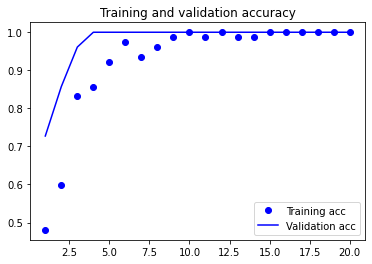

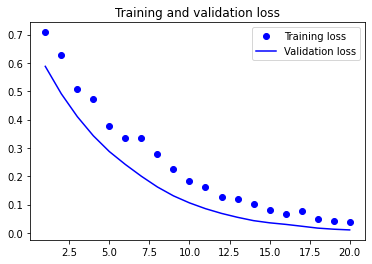

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#saving the model 
model.save('project_2_LSTM_CNN.h5')

In [ ]:
!pip3 install youtube-search-python
from youtubesearchpython import VideosSearch

videosSearch = VideosSearch('NoCopyrightSounds', limit = 2)

print(videosSearch.result())


     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 71kB 3.8MB/s 
     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
{'result': [{'type': 'video', 'id': 'ABuNwLP-z9o', 'title': '🔥 Top 50 NoCopyRightSounds | Best of NCS | Most viewed ! Gaming Music | The Best of All Time | 2020', 'publishedTime': '1 year ago', 'duration': '42:30', 'viewCount': {'text': '9,263,694 views', 'short': '9.2M views'}, 'thumbnails': [{'url': 'https://i.ytimg.com/vi/ABuNwLP-z9o/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLCy8-WQL-E7Hv6KkVf0dZP_xG6hLw', 'width': 360, 'height': 202}, {'url': 'https://i.ytimg.com/vi/ABuNwLP-z9o/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLBqTjoMCgLDTeOVtHqbx5TnjuREog', 'width': 720, 'height': 404}], 'descriptionSnippet': [{'text': 'Best of NCS | The Best of All Time Track list: 01. 0:00 Alan Walker - Fade 02. 4:20 Alan Walker - Spe

In [ ]:
!pip install youtube_dl

from __future__ import unicode_literals
import youtube_dl
ydl_opts = {}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=bbUy7QOE-38'])

from moviepy.editor import *
clip = VideoFileClip("/content/5 MINUTE Eye Makeup for Work _ School _ Everyday-bbUy7QOE-38.mp4").subclip(50,55)
clip.write_videofile("/content/test.mp4")

In [ ]:
import urllib.request
import urllib.parse
import re

#query_string = urllib.parse.urlencode({"search_query" : "Facial Makeup" })
html_content = urllib.request.urlopen(" https://www.youtube.com/results?search_query=cuttingvegetables")
search_results = re.findall(r"watch\?v=(\S{11})", html_content.read().decode())
for i in range(30):
 print("http://www.youtube.com/watch?v=" + search_results[i])

http://www.youtube.com/watch?v=p28wMbunulQ
http://www.youtube.com/watch?v=G-Fg7l7G1zw
http://www.youtube.com/watch?v=S_tTewiSuOs
http://www.youtube.com/watch?v=The6vuJocTI
http://www.youtube.com/watch?v=BrDkL5Y7kCs
http://www.youtube.com/watch?v=3lXlwRCjYLg
http://www.youtube.com/watch?v=VJNA4vrdWec
http://www.youtube.com/watch?v=i3cZCfTy0bA
http://www.youtube.com/watch?v=RUpVPjHEzZQ
http://www.youtube.com/watch?v=T9z0ALpY_i4
http://www.youtube.com/watch?v=7acPlYrVY34
http://www.youtube.com/watch?v=ye1Uang5yxE
http://www.youtube.com/watch?v=-2y3nyXRb0w
http://www.youtube.com/watch?v=w8KKapAa8OU
http://www.youtube.com/watch?v=gZPR03NiZbw
http://www.youtube.com/watch?v=m0WfCE0aTEU
http://www.youtube.com/watch?v=K_BpKaJmxac
http://www.youtube.com/watch?v=1eL7llVPuJg
http://www.youtube.com/watch?v=7kurbEksHvk
http://www.youtube.com/watch?v=8VBnaFhOEn8
http://www.youtube.com/watch?v=U5ddA4-hVAA
http://www.youtube.com/watch?v=LDz_acFP3RQ
http://www.youtube.com/watch?v=mnJewFAksAQ
http://www.